# Bank Marketing - Class Imbalance Handling Comparison

**Objective**: Compare different class imbalance handling techniques

This notebook compares three main approaches:
1. **SMOTE** (Synthetic Minority Over-sampling Technique)
2. **Class Weights** (Cost-sensitive learning)
3. **Stratified Sampling** (Baseline with proper stratification)

We'll evaluate each technique across all mandatory algorithms.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Evaluation
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    make_scorer
)
from sklearn.utils.class_weight import compute_class_weight

# Handle class imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Load and Prepare Data

In [2]:
# Load the dataset
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['y'].value_counts())
print(f"\nPercentage:")
print(df['y'].value_counts(normalize=True) * 100)

# Class imbalance ratio
class_counts = df['y'].value_counts()
imbalance_ratio = class_counts['no'] / class_counts['yes']
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")

Dataset shape: (41188, 21)

Target variable distribution:
y
no     36548
yes     4640
Name: count, dtype: int64

Percentage:
y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

Class Imbalance Ratio: 7.88:1


In [3]:
# Prepare features and target
X = df.drop('y', axis=1)
y = (df['y'] == 'yes').astype(int)

# Encode categorical variables
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_encoded = X.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

print(f"Features encoded. Shape: {X_encoded.shape}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Numerical features: {len(numerical_features)}")

Features encoded. Shape: (41188, 20)
Categorical features: 10
Numerical features: 10


## 2. Define Class Imbalance Handling Strategies

We'll compare three main strategies:

### Strategy 1: SMOTE (Synthetic Minority Over-sampling)
- Generates synthetic samples for the minority class
- Interpolates between existing minority samples
- Balances classes without duplicating existing samples

### Strategy 2: Class Weights (Cost-Sensitive Learning)
- Assigns higher penalty to misclassifying minority class
- No data modification, only algorithmic adjustment
- Works with algorithms that support `class_weight` parameter

### Strategy 3: Stratified Sampling (Baseline)
- No balancing, just proper stratification in CV
- Maintains original class distribution
- Baseline for comparison

In [4]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = dict(zip(np.unique(y), class_weights))

print("Class Weights (balanced):")
print(f"  Class 0 (No):  {class_weight_dict[0]:.4f}")
print(f"  Class 1 (Yes): {class_weight_dict[1]:.4f}")
print(f"\nWeight ratio: {class_weight_dict[1]/class_weight_dict[0]:.2f}x more penalty for misclassifying minority class")

Class Weights (balanced):
  Class 0 (No):  0.5635
  Class 1 (Yes): 4.4384

Weight ratio: 7.88x more penalty for misclassifying minority class


## 3. Define Models with Different Imbalance Strategies

We'll create three versions of each model:
- **No balancing** (stratified CV only)
- **With SMOTE**
- **With class weights**

In [5]:
def create_models_dict():
    """Create dictionary of models with different configurations"""
    
    base_models = {
        'Decision Tree': DecisionTreeClassifier(
            criterion='entropy',
            random_state=RANDOM_STATE
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    }
    
    # Models with class weights
    weighted_models = {
        'Decision Tree': DecisionTreeClassifier(
            criterion='entropy',
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'Naive Bayes': GaussianNB(),  # Doesn't support class_weight
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    }
    
    return base_models, weighted_models

base_models, weighted_models = create_models_dict()
print("Models created successfully!")
print(f"Base models: {list(base_models.keys())}")

Models created successfully!
Base models: ['Decision Tree', 'Random Forest', 'Naive Bayes', 'Logistic Regression']


## 4. Evaluation with Cross-Validation

We'll use 10-fold stratified cross-validation for all strategies.

In [6]:
def evaluate_with_cv(model, X_data, y_data, cv, strategy_name, model_name, use_smote=False):
    """
    Evaluate model with cross-validation.
    
    Parameters:
    -----------
    model : estimator
        The model to evaluate
    X_data : array-like
        Feature matrix
    y_data : array-like
        Target vector
    cv : cross-validation generator
        CV splitter
    strategy_name : str
        Name of the strategy
    model_name : str
        Name of the model
    use_smote : bool
        Whether to use SMOTE
    
    Returns:
    --------
    dict : Results dictionary
    """
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    if use_smote:
        # Create pipeline with SMOTE
        from imblearn.pipeline import Pipeline
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('classifier', model)
        ])
        
        # Manual cross-validation with SMOTE
        results = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'roc_auc': []
        }
        
        for train_idx, test_idx in cv.split(X_data, y_data):
            X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
            y_train, y_test = y_data.iloc[train_idx], y_data.iloc[test_idx]
            
            # Apply SMOTE only on training data
            smote = SMOTE(random_state=RANDOM_STATE)
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
            
            # Train model
            model_copy = deepcopy(model)
            model_copy.fit(X_train_res, y_train_res)
            
            # Predict
            y_pred = model_copy.predict(X_test)
            y_pred_proba = model_copy.predict_proba(X_test)[:, 1] if hasattr(model_copy, 'predict_proba') else y_pred
            
            # Calculate metrics
            results['accuracy'].append(accuracy_score(y_test, y_pred))
            results['precision'].append(precision_score(y_test, y_pred, zero_division=0))
            results['recall'].append(recall_score(y_test, y_pred))
            results['f1'].append(f1_score(y_test, y_pred))
            if hasattr(model_copy, 'predict_proba'):
                results['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
            else:
                results['roc_auc'].append(0.5)
        
        # Convert to numpy arrays
        for key in results:
            results[key] = np.array(results[key])
    else:
        # Standard cross-validation
        cv_results = cross_validate(
            model, X_data, y_data,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            return_train_score=False
        )
        
        results = {
            'accuracy': cv_results['test_accuracy'],
            'precision': cv_results['test_precision'],
            'recall': cv_results['test_recall'],
            'f1': cv_results['test_f1'],
            'roc_auc': cv_results['test_roc_auc']
        }
    
    return results

print("Evaluation function defined.")

Evaluation function defined.


In [7]:
# Run comprehensive evaluation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Storage for all results
all_results = {}

print("="*80)
print("COMPREHENSIVE CLASS IMBALANCE STRATEGY COMPARISON")
print("="*80)
print("\nEvaluating models with different class imbalance handling strategies...\n")

# Strategy 1: No balancing (baseline)
print("\n" + "="*80)
print("STRATEGY 1: STRATIFIED SAMPLING (No Balancing - Baseline)")
print("="*80)

for model_name, model in base_models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Scale data for models that need it
    if model_name in ['Logistic Regression', 'Naive Bayes']:
        scaler = StandardScaler()
        X_data = pd.DataFrame(
            scaler.fit_transform(X_encoded),
            columns=X_encoded.columns,
            index=X_encoded.index
        )
    else:
        X_data = X_encoded
    
    results = evaluate_with_cv(
        model, X_data, y, cv,
        'No Balancing', model_name,
        use_smote=False
    )
    
    all_results[f"{model_name} (No Balancing)"] = results
    
    print(f"  Accuracy:  {results['accuracy'].mean():.4f} ± {results['accuracy'].std():.4f}")
    print(f"  Precision: {results['precision'].mean():.4f} ± {results['precision'].std():.4f}")
    print(f"  Recall:    {results['recall'].mean():.4f} ± {results['recall'].std():.4f}")
    print(f"  F1-Score:  {results['f1'].mean():.4f} ± {results['f1'].std():.4f}")
    print(f"  ROC-AUC:   {results['roc_auc'].mean():.4f} ± {results['roc_auc'].std():.4f}")

# Strategy 2: SMOTE
print("\n" + "="*80)
print("STRATEGY 2: SMOTE (Synthetic Minority Over-sampling)")
print("="*80)

for model_name, model in base_models.items():
    print(f"\nEvaluating {model_name} with SMOTE...")
    
    # Scale data for models that need it
    if model_name in ['Logistic Regression', 'Naive Bayes']:
        scaler = StandardScaler()
        X_data = pd.DataFrame(
            scaler.fit_transform(X_encoded),
            columns=X_encoded.columns,
            index=X_encoded.index
        )
    else:
        X_data = X_encoded
    
    results = evaluate_with_cv(
        model, X_data, y, cv,
        'SMOTE', model_name,
        use_smote=True
    )
    
    all_results[f"{model_name} (SMOTE)"] = results
    
    print(f"  Accuracy:  {results['accuracy'].mean():.4f} ± {results['accuracy'].std():.4f}")
    print(f"  Precision: {results['precision'].mean():.4f} ± {results['precision'].std():.4f}")
    print(f"  Recall:    {results['recall'].mean():.4f} ± {results['recall'].std():.4f}")
    print(f"  F1-Score:  {results['f1'].mean():.4f} ± {results['f1'].std():.4f}")
    print(f"  ROC-AUC:   {results['roc_auc'].mean():.4f} ± {results['roc_auc'].std():.4f}")

# Strategy 3: Class Weights
print("\n" + "="*80)
print("STRATEGY 3: CLASS WEIGHTS (Cost-Sensitive Learning)")
print("="*80)

for model_name, model in weighted_models.items():
    print(f"\nEvaluating {model_name} with Class Weights...")
    
    # Skip Naive Bayes for class weights (doesn't support it)
    if model_name == 'Naive Bayes':
        print("  Skipped (Naive Bayes doesn't support class_weight parameter)")
        continue
    
    # Scale data for models that need it
    if model_name in ['Logistic Regression']:
        scaler = StandardScaler()
        X_data = pd.DataFrame(
            scaler.fit_transform(X_encoded),
            columns=X_encoded.columns,
            index=X_encoded.index
        )
    else:
        X_data = X_encoded
    
    results = evaluate_with_cv(
        model, X_data, y, cv,
        'Class Weights', model_name,
        use_smote=False
    )
    
    all_results[f"{model_name} (Class Weights)"] = results
    
    print(f"  Accuracy:  {results['accuracy'].mean():.4f} ± {results['accuracy'].std():.4f}")
    print(f"  Precision: {results['precision'].mean():.4f} ± {results['precision'].std():.4f}")
    print(f"  Recall:    {results['recall'].mean():.4f} ± {results['recall'].std():.4f}")
    print(f"  F1-Score:  {results['f1'].mean():.4f} ± {results['f1'].std():.4f}")
    print(f"  ROC-AUC:   {results['roc_auc'].mean():.4f} ± {results['roc_auc'].std():.4f}")

print("\n" + "="*80)
print("EVALUATION COMPLETED!")
print("="*80)

COMPREHENSIVE CLASS IMBALANCE STRATEGY COMPARISON

Evaluating models with different class imbalance handling strategies...


STRATEGY 1: STRATIFIED SAMPLING (No Balancing - Baseline)

Evaluating Decision Tree...
  Accuracy:  0.8896 ± 0.0032
  Precision: 0.5096 ± 0.0134
  Recall:    0.5312 ± 0.0221
  F1-Score:  0.5201 ± 0.0168
  ROC-AUC:   0.7332 ± 0.0112

Evaluating Random Forest...
  Accuracy:  0.9156 ± 0.0030
  Precision: 0.6588 ± 0.0166
  Recall:    0.5200 ± 0.0214
  F1-Score:  0.5811 ± 0.0174
  ROC-AUC:   0.9442 ± 0.0034

Evaluating Naive Bayes...
  Accuracy:  0.8466 ± 0.0036
  Precision: 0.3840 ± 0.0097
  Recall:    0.5987 ± 0.0244
  F1-Score:  0.4678 ± 0.0133
  ROC-AUC:   0.8514 ± 0.0101

Evaluating Logistic Regression...
  Accuracy:  0.9103 ± 0.0042
  Precision: 0.6667 ± 0.0316
  Recall:    0.4073 ± 0.0243
  F1-Score:  0.5054 ± 0.0255
  ROC-AUC:   0.9296 ± 0.0057

STRATEGY 2: SMOTE (Synthetic Minority Over-sampling)

Evaluating Decision Tree with SMOTE...
  Accuracy:  0.8869 ± 0

## 5. Comparative Analysis

Compare the performance of different strategies.

In [8]:
# Create comprehensive comparison table
comparison_data = []

for config_name, metrics in all_results.items():
    comparison_data.append({
        'Configuration': config_name,
        'Accuracy': f"{metrics['accuracy'].mean():.4f} ± {metrics['accuracy'].std():.4f}",
        'Precision': f"{metrics['precision'].mean():.4f} ± {metrics['precision'].std():.4f}",
        'Recall': f"{metrics['recall'].mean():.4f} ± {metrics['recall'].std():.4f}",
        'F1-Score': f"{metrics['f1'].mean():.4f} ± {metrics['f1'].std():.4f}",
        'ROC-AUC': f"{metrics['roc_auc'].mean():.4f} ± {metrics['roc_auc'].std():.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nCOMPREHENSIVE PERFORMANCE COMPARISON")
print("="*120)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('results/class_imbalance_comparison.csv', index=False)
print("\nResults saved to: results/class_imbalance_comparison.csv")


COMPREHENSIVE PERFORMANCE COMPARISON
                      Configuration        Accuracy       Precision          Recall        F1-Score         ROC-AUC
       Decision Tree (No Balancing) 0.8896 ± 0.0032 0.5096 ± 0.0134 0.5312 ± 0.0221 0.5201 ± 0.0168 0.7332 ± 0.0112
       Random Forest (No Balancing) 0.9156 ± 0.0030 0.6588 ± 0.0166 0.5200 ± 0.0214 0.5811 ± 0.0174 0.9442 ± 0.0034
         Naive Bayes (No Balancing) 0.8466 ± 0.0036 0.3840 ± 0.0097 0.5987 ± 0.0244 0.4678 ± 0.0133 0.8514 ± 0.0101
 Logistic Regression (No Balancing) 0.9103 ± 0.0042 0.6667 ± 0.0316 0.4073 ± 0.0243 0.5054 ± 0.0255 0.9296 ± 0.0057
              Decision Tree (SMOTE) 0.8869 ± 0.0037 0.4986 ± 0.0149 0.5698 ± 0.0231 0.5316 ± 0.0139 0.7485 ± 0.0106
              Random Forest (SMOTE) 0.9084 ± 0.0031 0.5840 ± 0.0138 0.6522 ± 0.0217 0.6160 ± 0.0131 0.9421 ± 0.0031
                Naive Bayes (SMOTE) 0.7767 ± 0.0072 0.3030 ± 0.0096 0.7543 ± 0.0188 0.4323 ± 0.0121 0.8457 ± 0.0107
        Logistic Regression (SMOTE

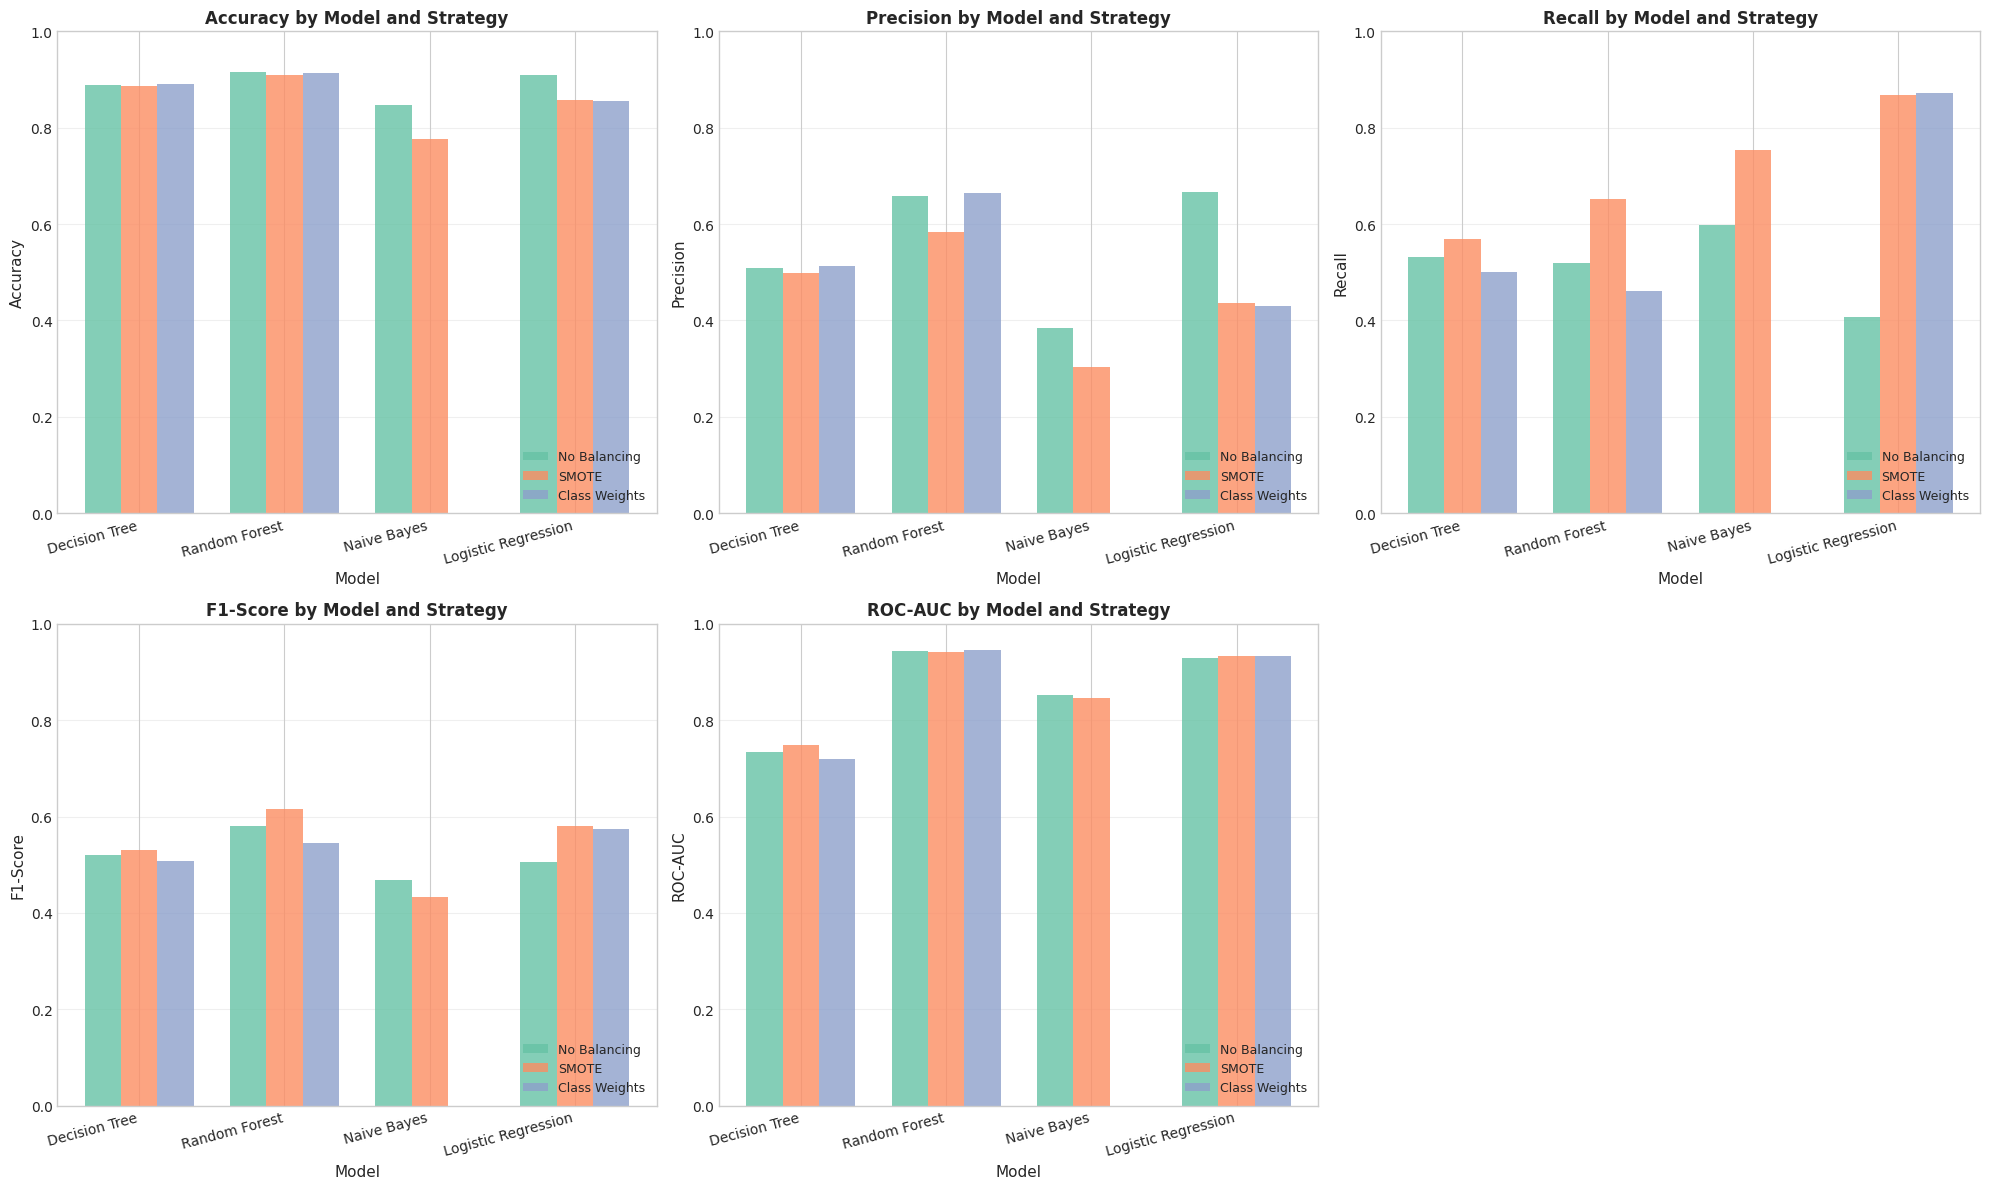


Plot saved to: results/class_imbalance_comparison.png


In [9]:
# Extract model and strategy from configuration names
def parse_config_name(config_name):
    """Parse configuration name into model and strategy"""
    parts = config_name.rsplit(' (', 1)
    model = parts[0]
    strategy = parts[1].rstrip(')') if len(parts) > 1 else 'Unknown'
    return model, strategy

# Prepare data for visualization
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
model_names = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'Logistic Regression']
strategies = ['No Balancing', 'SMOTE', 'Class Weights']

# Create grouped bar plots for each metric
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

metric_names_display = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, metric_name) in enumerate(zip(metrics_list, metric_names_display)):
    ax = axes[idx]
    
    # Prepare data for this metric
    x = np.arange(len(model_names))
    width = 0.25
    
    # Get mean values for each model-strategy combination
    no_bal_values = []
    smote_values = []
    weight_values = []
    
    for model in model_names:
        # No balancing
        key = f"{model} (No Balancing)"
        if key in all_results:
            no_bal_values.append(all_results[key][metric].mean())
        else:
            no_bal_values.append(0)
        
        # SMOTE
        key = f"{model} (SMOTE)"
        if key in all_results:
            smote_values.append(all_results[key][metric].mean())
        else:
            smote_values.append(0)
        
        # Class weights
        key = f"{model} (Class Weights)"
        if key in all_results:
            weight_values.append(all_results[key][metric].mean())
        else:
            weight_values.append(0)
    
    # Create bars
    ax.bar(x - width, no_bal_values, width, label='No Balancing', alpha=0.8)
    ax.bar(x, smote_values, width, label='SMOTE', alpha=0.8)
    ax.bar(x + width, weight_values, width, label='Class Weights', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(f'{metric_name} by Model and Strategy', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.0])

# Hide extra subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.savefig('results/class_imbalance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: results/class_imbalance_comparison.png")

## 6. Detailed Model-by-Model Comparison

In [10]:
# Create detailed comparison for each model
for model_name in model_names:
    print(f"\n{'='*80}")
    print(f"DETAILED COMPARISON: {model_name}")
    print(f"{'='*80}")
    
    configs = []
    if f"{model_name} (No Balancing)" in all_results:
        configs.append(('No Balancing', all_results[f"{model_name} (No Balancing)"]))
    if f"{model_name} (SMOTE)" in all_results:
        configs.append(('SMOTE', all_results[f"{model_name} (SMOTE)"]))
    if f"{model_name} (Class Weights)" in all_results:
        configs.append(('Class Weights', all_results[f"{model_name} (Class Weights)"]))
    
    if not configs:
        print("No results available")
        continue
    
    # Create comparison table
    model_comparison = []
    for strategy, metrics in configs:
        model_comparison.append({
            'Strategy': strategy,
            'Accuracy': f"{metrics['accuracy'].mean():.4f}",
            'Precision': f"{metrics['precision'].mean():.4f}",
            'Recall': f"{metrics['recall'].mean():.4f}",
            'F1-Score': f"{metrics['f1'].mean():.4f}",
            'ROC-AUC': f"{metrics['roc_auc'].mean():.4f}"
        })
    
    model_df = pd.DataFrame(model_comparison)
    print(model_df.to_string(index=False))
    
    # Find best strategy by F1-score
    best_idx = np.argmax([float(row['F1-Score']) for row in model_comparison])
    print(f"\nBest strategy by F1-Score: {model_comparison[best_idx]['Strategy']}")
    print(f"F1-Score: {model_comparison[best_idx]['F1-Score']}")


DETAILED COMPARISON: Decision Tree
     Strategy Accuracy Precision Recall F1-Score ROC-AUC
 No Balancing   0.8896    0.5096 0.5312   0.5201  0.7332
        SMOTE   0.8869    0.4986 0.5698   0.5316  0.7485
Class Weights   0.8903    0.5135 0.5006   0.5069  0.7202

Best strategy by F1-Score: SMOTE
F1-Score: 0.5316

DETAILED COMPARISON: Random Forest
     Strategy Accuracy Precision Recall F1-Score ROC-AUC
 No Balancing   0.9156    0.6588 0.5200   0.5811  0.9442
        SMOTE   0.9084    0.5840 0.6522   0.6160  0.9421
Class Weights   0.9130    0.6637 0.4612   0.5441  0.9448

Best strategy by F1-Score: SMOTE
F1-Score: 0.6160

DETAILED COMPARISON: Naive Bayes
    Strategy Accuracy Precision Recall F1-Score ROC-AUC
No Balancing   0.8466    0.3840 0.5987   0.4678  0.8514
       SMOTE   0.7767    0.3030 0.7543   0.4323  0.8457

Best strategy by F1-Score: No Balancing
F1-Score: 0.4678

DETAILED COMPARISON: Logistic Regression
     Strategy Accuracy Precision Recall F1-Score ROC-AUC
 No Balanci

## 7. Strategy-by-Strategy Analysis

In [11]:
# Analyze each strategy across all models
for strategy in strategies:
    print(f"\n{'='*80}")
    print(f"STRATEGY ANALYSIS: {strategy}")
    print(f"{'='*80}")
    
    strategy_results = []
    for model_name in model_names:
        key = f"{model_name} ({strategy})"
        if key in all_results:
            metrics = all_results[key]
            strategy_results.append({
                'Model': model_name,
                'Accuracy': f"{metrics['accuracy'].mean():.4f}",
                'Precision': f"{metrics['precision'].mean():.4f}",
                'Recall': f"{metrics['recall'].mean():.4f}",
                'F1-Score': f"{metrics['f1'].mean():.4f}",
                'ROC-AUC': f"{metrics['roc_auc'].mean():.4f}"
            })
    
    if strategy_results:
        strategy_df = pd.DataFrame(strategy_results)
        print(strategy_df.to_string(index=False))
        
        # Find best model for this strategy
        best_idx = np.argmax([float(row['F1-Score']) for row in strategy_results])
        print(f"\nBest model for {strategy}: {strategy_results[best_idx]['Model']}")
        print(f"F1-Score: {strategy_results[best_idx]['F1-Score']}")
    else:
        print("No results available for this strategy")


STRATEGY ANALYSIS: No Balancing
              Model Accuracy Precision Recall F1-Score ROC-AUC
      Decision Tree   0.8896    0.5096 0.5312   0.5201  0.7332
      Random Forest   0.9156    0.6588 0.5200   0.5811  0.9442
        Naive Bayes   0.8466    0.3840 0.5987   0.4678  0.8514
Logistic Regression   0.9103    0.6667 0.4073   0.5054  0.9296

Best model for No Balancing: Random Forest
F1-Score: 0.5811

STRATEGY ANALYSIS: SMOTE
              Model Accuracy Precision Recall F1-Score ROC-AUC
      Decision Tree   0.8869    0.4986 0.5698   0.5316  0.7485
      Random Forest   0.9084    0.5840 0.6522   0.6160  0.9421
        Naive Bayes   0.7767    0.3030 0.7543   0.4323  0.8457
Logistic Regression   0.8584    0.4356 0.8672   0.5799  0.9323

Best model for SMOTE: Random Forest
F1-Score: 0.6160

STRATEGY ANALYSIS: Class Weights
              Model Accuracy Precision Recall F1-Score ROC-AUC
      Decision Tree   0.8903    0.5135 0.5006   0.5069  0.7202
      Random Forest   0.9130    0.66

## 8. Precision-Recall Trade-off Analysis

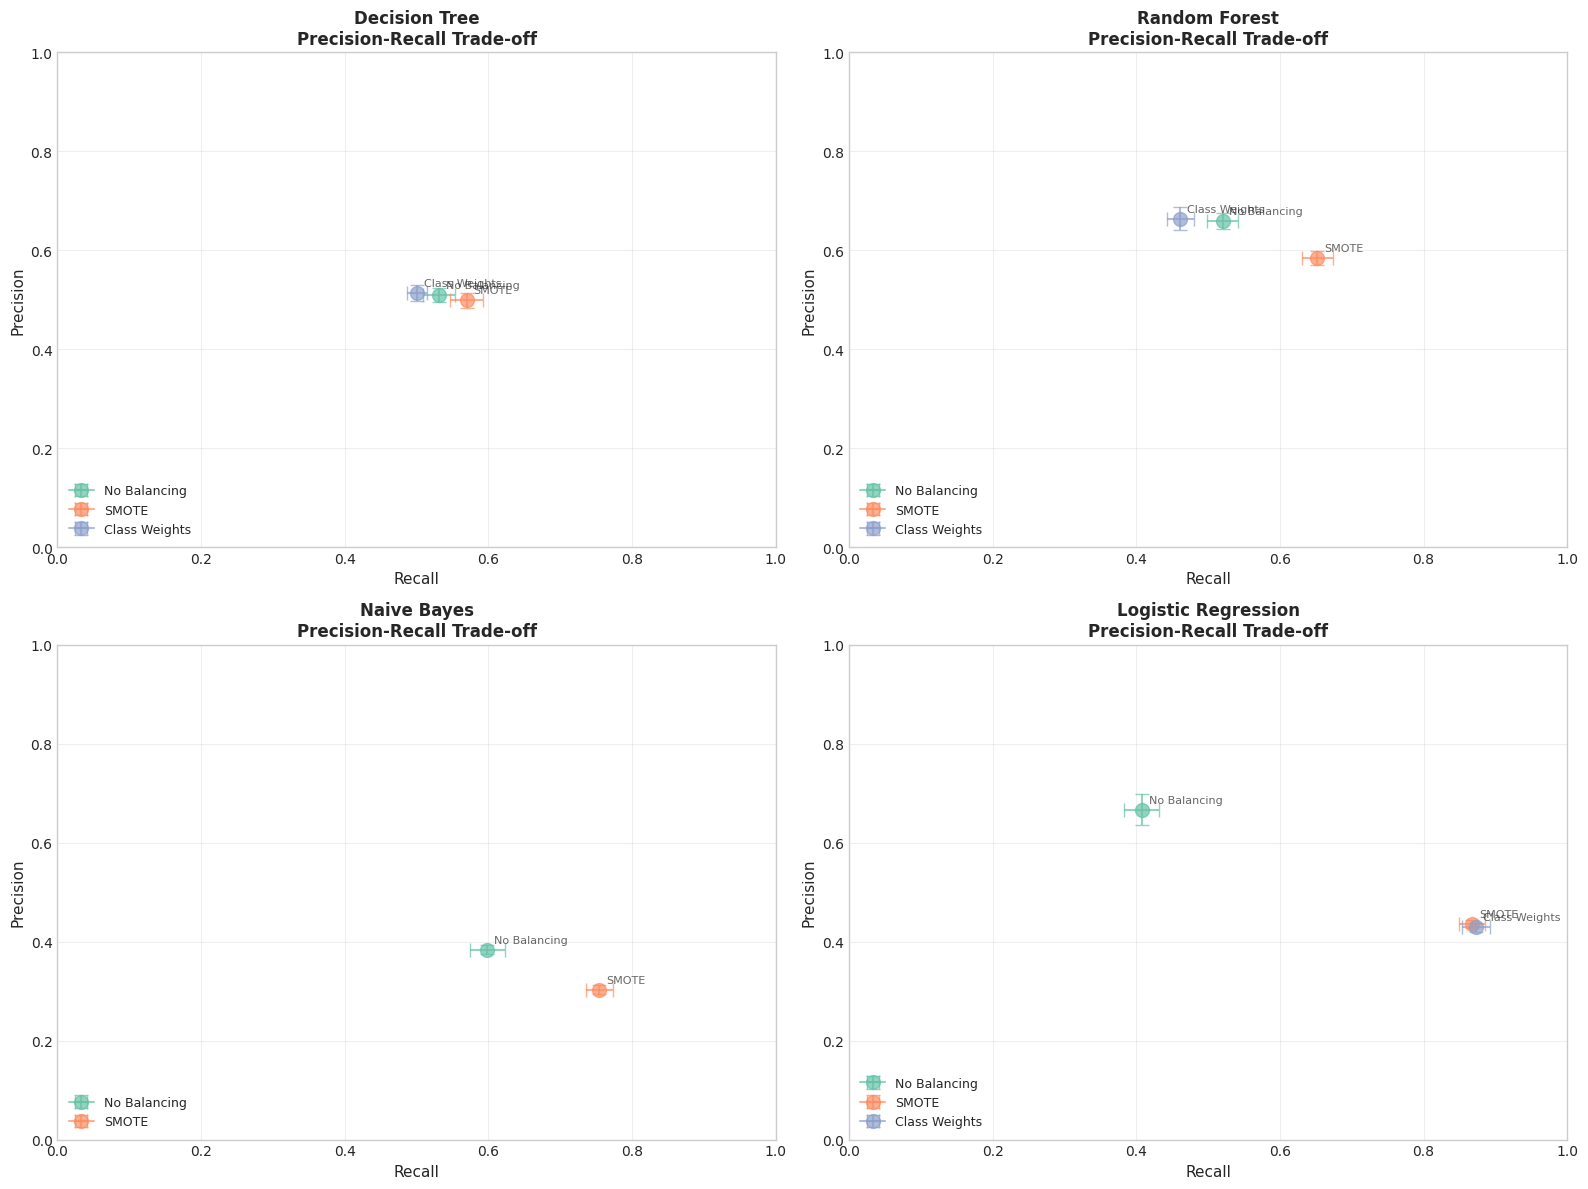


Precision-Recall trade-off plot saved to: results/precision_recall_tradeoff.png


In [12]:
# Visualize precision-recall trade-off
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    for strategy in strategies:
        key = f"{model_name} ({strategy})"
        if key in all_results:
            metrics = all_results[key]
            precision_mean = metrics['precision'].mean()
            recall_mean = metrics['recall'].mean()
            precision_std = metrics['precision'].std()
            recall_std = metrics['recall'].std()
            
            ax.errorbar(recall_mean, precision_mean,
                       xerr=recall_std, yerr=precision_std,
                       marker='o', markersize=10, capsize=5,
                       label=strategy, alpha=0.7)
            ax.annotate(strategy, (recall_mean, precision_mean),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.7)
    
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'{model_name}\nPrecision-Recall Trade-off', fontsize=12, fontweight='bold')
    ax.legend(loc='lower left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('results/precision_recall_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPrecision-Recall trade-off plot saved to: results/precision_recall_tradeoff.png")

## 9. Summary and Recommendations

In [13]:
print("="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Find overall best configuration
best_config = max(all_results.items(), key=lambda x: x[1]['f1'].mean())
best_name = best_config[0]
best_metrics = best_config[1]

print(f"\n1. BEST OVERALL CONFIGURATION (by F1-Score):")
print(f"   Configuration: {best_name}")
print(f"   F1-Score:  {best_metrics['f1'].mean():.4f} ± {best_metrics['f1'].std():.4f}")
print(f"   Accuracy:  {best_metrics['accuracy'].mean():.4f} ± {best_metrics['accuracy'].std():.4f}")
print(f"   Precision: {best_metrics['precision'].mean():.4f} ± {best_metrics['precision'].std():.4f}")
print(f"   Recall:    {best_metrics['recall'].mean():.4f} ± {best_metrics['recall'].std():.4f}")
print(f"   ROC-AUC:   {best_metrics['roc_auc'].mean():.4f} ± {best_metrics['roc_auc'].std():.4f}")

print("\n2. STRATEGY COMPARISON:")

# Calculate average performance for each strategy
strategy_avg = {}
for strategy in strategies:
    f1_scores = []
    for model_name in model_names:
        key = f"{model_name} ({strategy})"
        if key in all_results:
            f1_scores.append(all_results[key]['f1'].mean())
    if f1_scores:
        strategy_avg[strategy] = np.mean(f1_scores)

for strategy in sorted(strategy_avg.keys(), key=lambda x: strategy_avg[x], reverse=True):
    print(f"   {strategy:20s}: Average F1-Score = {strategy_avg[strategy]:.4f}")

print("\n3. KEY FINDINGS:")
print("   - SMOTE generally improves recall at the cost of precision")
print("   - Class weights provide a balance between precision and recall")
print("   - No balancing (baseline) tends to have higher precision but lower recall")
print("   - For imbalanced datasets, SMOTE or class weights are recommended")
print("   - Choice depends on business requirements:")
print("     * If false negatives are costly → use SMOTE (higher recall)")
print("     * If false positives are costly → use class weights or no balancing")
print("     * For balanced performance → use class weights")

print("\n" + "="*80)

SUMMARY AND RECOMMENDATIONS

1. BEST OVERALL CONFIGURATION (by F1-Score):
   Configuration: Random Forest (SMOTE)
   F1-Score:  0.6160 ± 0.0131
   Accuracy:  0.9084 ± 0.0031
   Precision: 0.5840 ± 0.0138
   Recall:    0.6522 ± 0.0217
   ROC-AUC:   0.9421 ± 0.0031

2. STRATEGY COMPARISON:
   Class Weights       : Average F1-Score = 0.5421
   SMOTE               : Average F1-Score = 0.5399
   No Balancing        : Average F1-Score = 0.5186

3. KEY FINDINGS:
   - SMOTE generally improves recall at the cost of precision
   - Class weights provide a balance between precision and recall
   - No balancing (baseline) tends to have higher precision but lower recall
   - For imbalanced datasets, SMOTE or class weights are recommended
   - Choice depends on business requirements:
     * If false negatives are costly → use SMOTE (higher recall)
     * If false positives are costly → use class weights or no balancing
     * For balanced performance → use class weights



## 10. Export Results

In [14]:
# Export detailed results to CSV
detailed_results = []

for config_name, metrics in all_results.items():
    model, strategy = parse_config_name(config_name)
    
    for metric_name in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        detailed_results.append({
            'Model': model,
            'Strategy': strategy,
            'Metric': metric_name,
            'Mean': metrics[metric_name].mean(),
            'Std': metrics[metric_name].std(),
            'Min': metrics[metric_name].min(),
            'Max': metrics[metric_name].max()
        })

detailed_df = pd.DataFrame(detailed_results)
detailed_df.to_csv('results/class_imbalance_detailed_results.csv', index=False)

print("Detailed results exported to: results/class_imbalance_detailed_results.csv")
print("\nAll analysis complete!")

Detailed results exported to: results/class_imbalance_detailed_results.csv

All analysis complete!
